# All you need is love... and a good chemical affinity #

#here textual description - similar to the website. for now produce the code that needs to be put in the website (plots). Some textual descriptions can be the same of the 'original' results notebook, just to explain the choices.
1) Organism distribution

In [1]:
#import all necessary libraries and eventually ignore warnings to have better looking outputs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import data_utils, evaluation_utils
from src.data.some_dataloader import get_dataset, get_dataset2
from src.scripts import rdkit_extraction
from src.utils import evaluation_utils
from sklearn.cluster import KMeans,SpectralClustering
import os
import zipfile
#imports to get rid of Morgan Fingerprint warnings
import warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')


<Axes: xlabel='total_bill', ylabel='Count'>

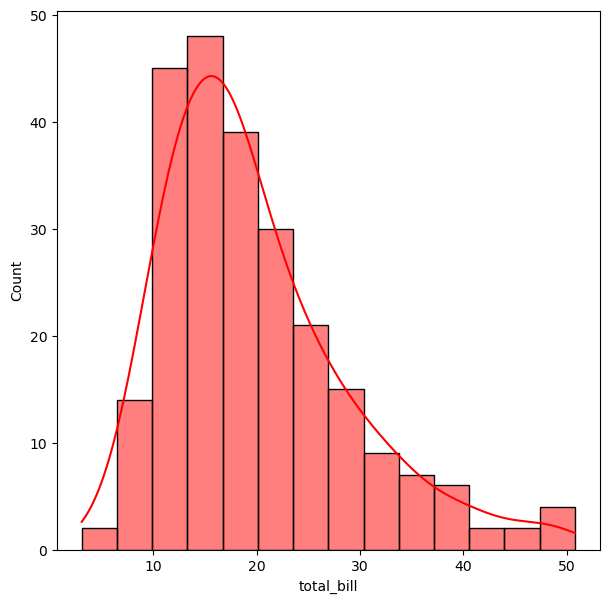

In [16]:
# Palette personalizzata

custom_palette = sns.color_palette(["#FF0000", "#DC143C", "#B22222", "#8B0000", "#CD5C5C"])
#custom_palette = sns.color_palette(["#FF0000", "#FF4500", "#FF6347", "#FF1493", "#FF8C00"])

sns.set_palette(custom_palette)


First of all, we can import the dataset with the ad-hoc function `get_dataset_complete`.

In [3]:
#read the complete dataset

df = get_dataset2()
print(f'BindingDB dataset rows: {df.shape[0]}')
print(f'BindingDB dataset columns: {df.shape[1]}')

BindingDB dataset rows: 2913040
BindingDB dataset columns: 194


The `Binding_DB` dataset contains rows with binding affinities between ligands (drugs) and proteins. Such proteins are implicated in specific disease pathways, so in a 'system of interacting proteins whose atypical activity collectively produces some disease phenotype'. As each row represents the resulted affinity from a specific experiment, this means that the 'target organism' column identifies the species (or type of living organism) that produces the protein, enzyme, receptor, or other molecule being studied in the experiment. Such organism depends on the type of disease, and can be for example 'homo sapiens' if the disease human-derived, a bacteria if the disease derives from a bacteria, or a virus, with the same logic. To get a first intuition of which are such targets, we can visualize the target distirbution.

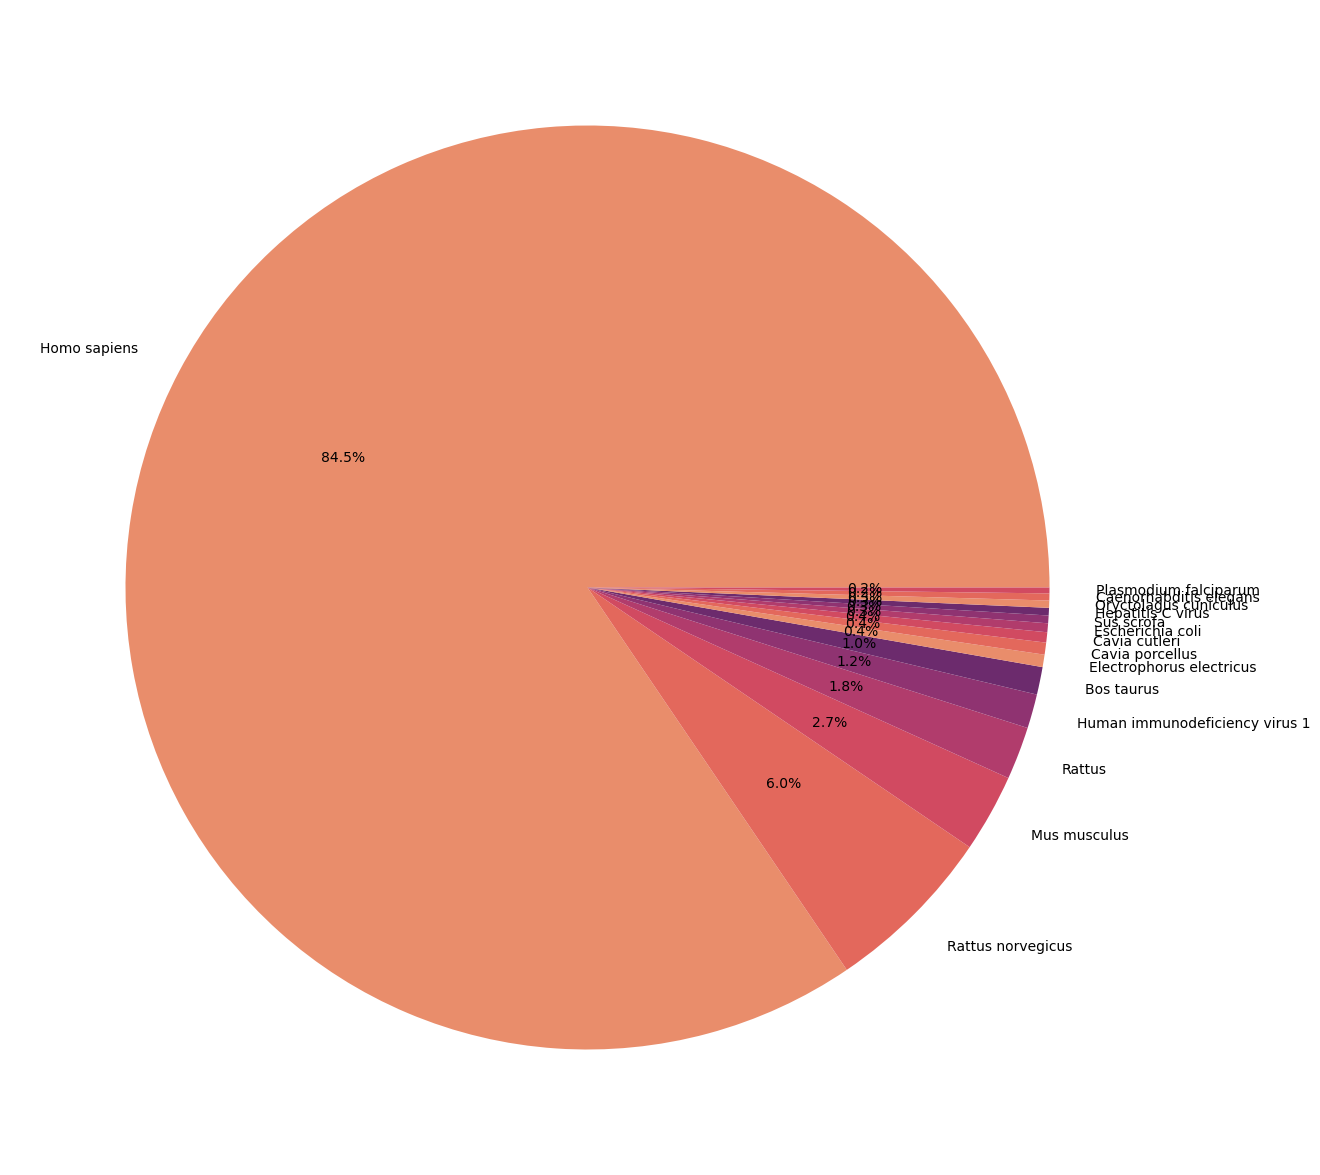

In [4]:
evaluation_utils.plot_target_organism_distribution(df)

We can notice that the majority of targeted organisms are humans, meaning that the diseases are human-generated. Still, we can also see that there is a big effort in HIV1 research, being it still represented.

In [5]:
most_targeted_organisms = df['Target Source Organism According to Curator or DataSource'].value_counts()[:20].reset_index()
most_targeted_organisms

,Target Source Organism According to Curator or DataSource,count
0,Homo sapiens,1541006
1,Rattus norvegicus,109758
2,Mus musculus,49854
3,Rattus,33713
4,Human immunodeficiency virus 1,21780
5,Bos taurus,17618
6,Electrophorus electricus,7921
7,Cavia porcellus,7639
8,Cavia cutleri,6540
9,Escherichia coli,5651


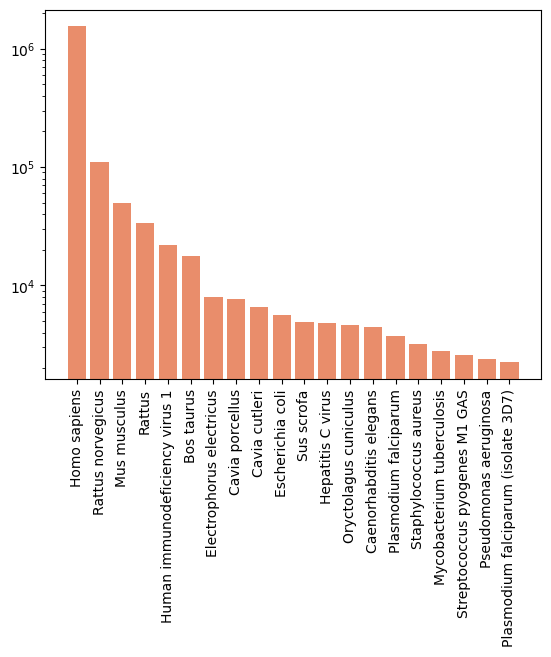

In [6]:
plt.bar(x = most_targeted_organisms['Target Source Organism According to Curator or DataSource'], height=most_targeted_organisms['count'], log = True)
plt.xticks(rotation = 90)
plt.show()

In [7]:
hiv = df[df['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1']
len(hiv)

21780

In the dataset, four affinity metric are available:

1. **Ki (Inhibition Constant)**: Represents the concentration at which an inhibitor ligand occupies 50% of the receptor or enzyme sites, assuming no competing ligands are present. It quantifies the affinity of the inhibitor for the target under equilibrium conditions.

2. **IC50 (Half Maximal Inhibitory Concentration)**: Represents the concentration of a drug needed to inhibit a specific biological or biochemical function by 50%. It measures how much drug is required to achieve a halfway inhibition of the target activity in a given experimental setup.

3. **Kd (Dissociation Constant)**: Represents the concentration at which 50% of the binding sites on the target (e.g., receptor or enzyme) are occupied by the ligand. It quantifies the equilibrium affinity between a ligand and its target, with lower values indicating tighter binding.

4. **EC50 (Half Maximal Effective Concentration)**: Represents the concentration of a drug needed to produce 50% of its maximal effect in a biological system. It is an indicator of the drug's potency, reflecting the concentration required to achieve a halfway maximal response.

These metrics are interrelated but not directly interchangeable, although an approximate relationship between **Ki** and **IC50**, the Cheng-Prusoff equation, does exist. Unfortunately, strict conditions need to be satisfies, so we won't use it in our analysis.

Therefore, in the next cells we will select the most represented metric in our dataset and get rid of rows where it's not provided.

c:\Users\simon\Desktop\EPFL\ADA\P3\src\utils\evaluation_utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[metrics] = df[metrics].replace({r'^>.*$': np.nan, r'^<.*$': np.nan}, regex=True)
c:\Users\simon\Desktop\EPFL\ADA\P3\src\utils\evaluation_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[metric] = pd.to_numeric(df[metric], errors='coerce')


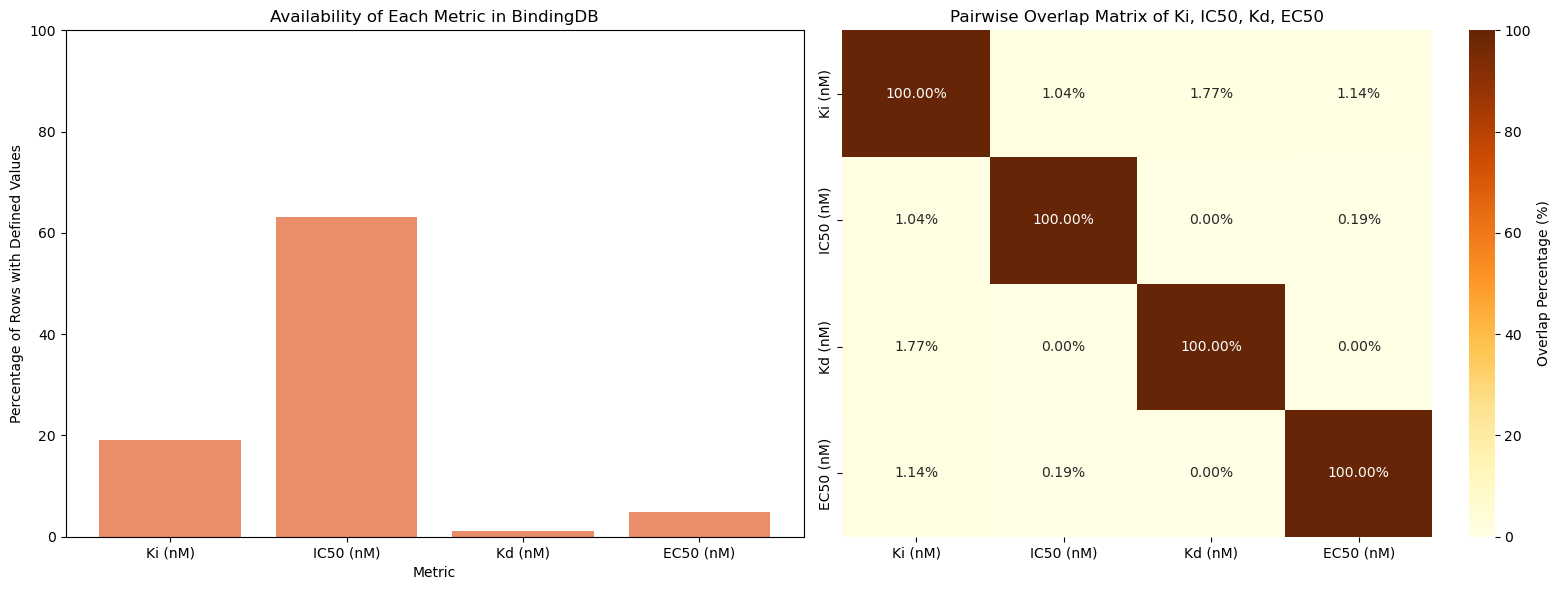

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax = axes.flatten()

evaluation_utils.plot_metric_availability(hiv, ax=ax[0])
evaluation_utils.plot_overlap_matrix(hiv, ax=ax[1])

plt.tight_layout()
plt.show()

We observe that IC50 is given in more than 50% of the rows, while the other metrics are less represented. In the overlap matrix, we also observe that metrics rarely overlap, so it makes sense to pick only one of the four for the analysis.  

In the next cell, we use the `data_utils.select_metric` function to select only rows with IC50 for our analyses.  

We also get rid of columns where more than 50% of entries are `NaN` through the `data_utils.clean_na_columns` function. Non-numeric entries that were not `NaN` (e.g., `'> 50000'`) were also removed, since they would negatively affect the computation of statistics like the mean.



In [9]:
hiv = data_utils.select_metric(hiv, 'IC50 (nM)')
hiv = data_utils.clean_na_columns(hiv)
print(f'Rows of STD dataset where IC50 is given: {hiv.shape[0]}')
print(f'Columns of STD dataset where nan rows are less than 50% of the total: {hiv.shape[1]}')

c:\Users\simon\Desktop\EPFL\ADA\P3\src\utils\data_utils.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[metric] = pd.to_numeric(df[metric], errors = 'coerce')


Rows of STD dataset where IC50 is given: 13754
Columns of STD dataset where nan rows are less than 50% of the total: 27


# Focus on target proteins
Having selected the target organism, the Human Immunodeficiency Virus, we want now to study how we actually target it. We first focus on the target proteins in this virus:

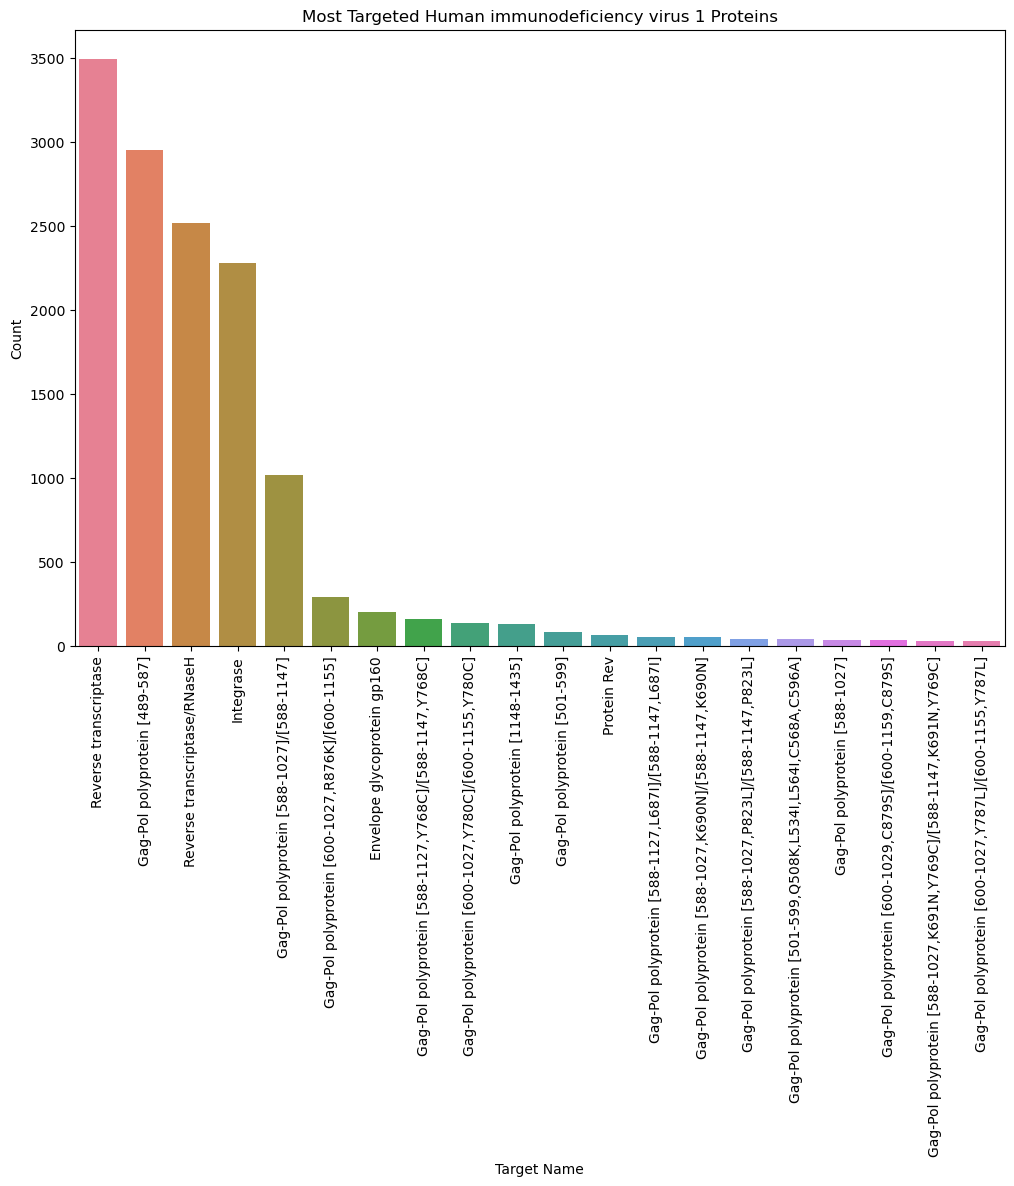

In [10]:
evaluation_utils.plot_most_targeted_proteins(hiv)

TO DO: ADD CLEANING FUNCTION THAT GROUPS TOGETHER SAME PROTEINS NAMED DIFFERENTLY

In [11]:
hiv['Target Name'] = hiv['Target Name'].str.replace("Dimer of ", "", regex=False)
hiv['Target Name'] = hiv['Target Name'].str.replace("Reverse transcriptase protein", "Reverse transcriptase", regex=False)

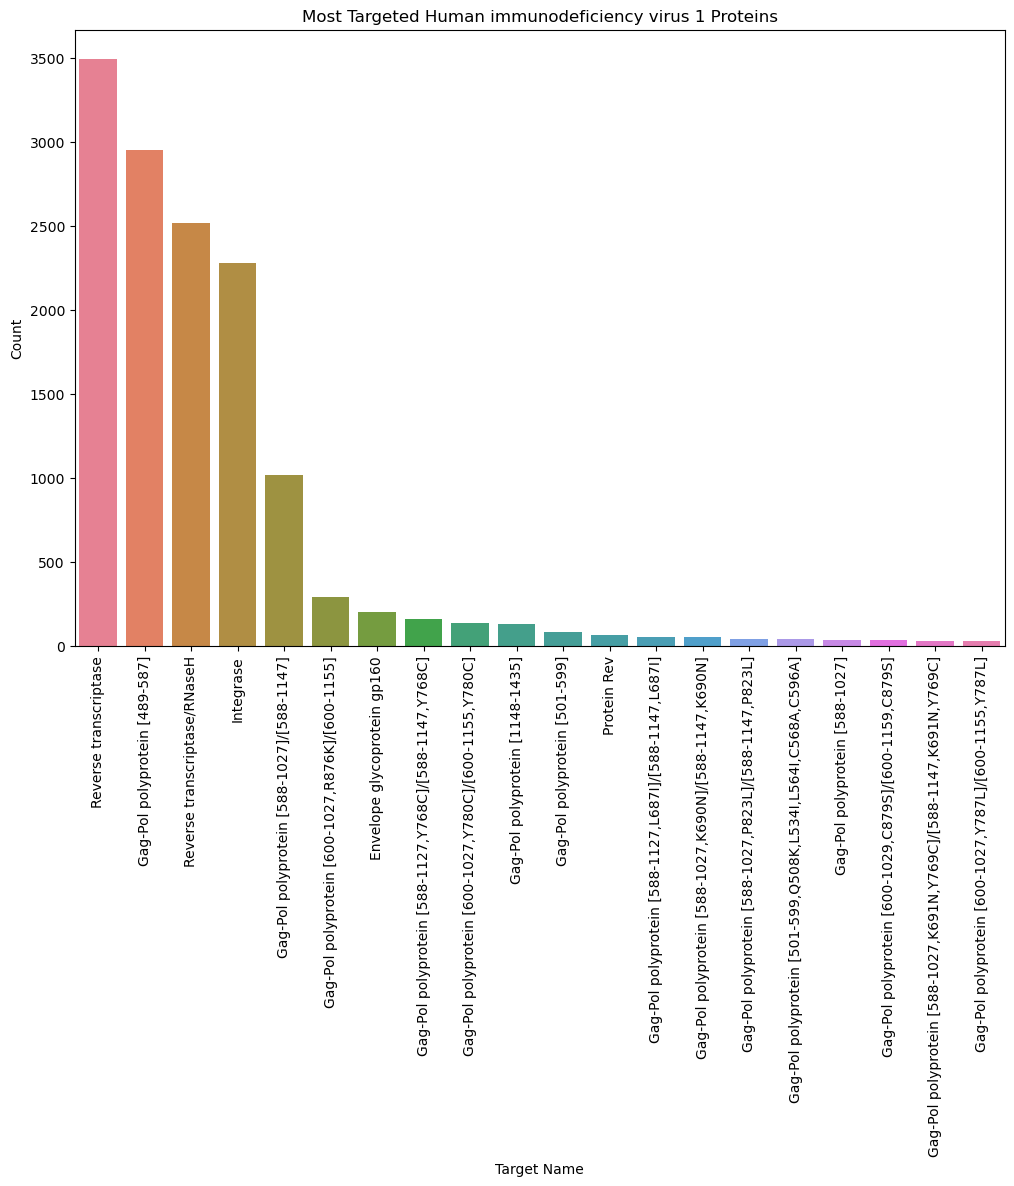

In [12]:
evaluation_utils.plot_most_targeted_proteins(hiv)

In [13]:
hivGagPol = hiv[hiv['Target Name'].str.contains('Gag-Pol', na=False)]


In [14]:
hiv_condensed = hiv.copy()
hiv_condensed['Target Name'] = hiv['Target Name'].apply(lambda x: 'Gag-Pol polyprotein' if 'Gag-Pol' in x else x)

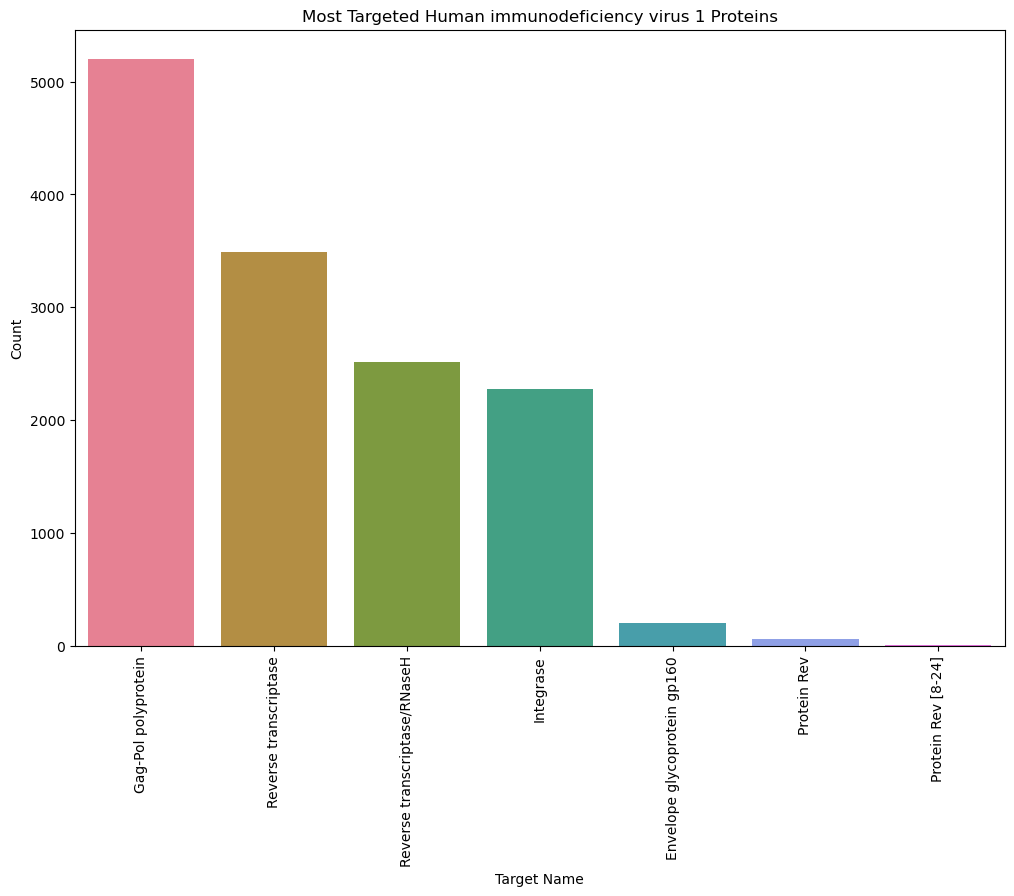

In [15]:
evaluation_utils.plot_most_targeted_proteins(hiv_condensed)

### Targeted HIV-1 Proteins

We clearly see that the most targeted proteins in HIV-1 are:

- **Reverse transcriptase**
- **Gag-Pol polyprotein**
- **Integrase**

#### Reverse Transcriptase
Reverse transcriptase is an enzyme that plays a critical role in the HIV lifecycle by converting the virus's single-stranded RNA genome into double-stranded DNA once the virus enters a host cell. This conversion allows the viral DNA to integrate into the host’s genome, a necessary step for HIV replication.

Due to its essential function, reverse transcriptase is a major target for antiretroviral drugs. Two primary classes of inhibitors target this enzyme:
- **Nucleoside Reverse Transcriptase Inhibitors (NRTIs)**: These drugs mimic DNA building blocks, causing premature termination of the DNA chain and stopping HIV replication.
- **Non-Nucleoside Reverse Transcriptase Inhibitors (NNRTIs)**: These drugs bind directly to reverse transcriptase, blocking its activity by altering the enzyme's shape.

#### Gag-Pol Polyprotein
The Gag-Pol polyprotein is a precursor protein produced from the HIV genome that contains multiple essential viral components, including reverse transcriptase, protease, and integrase. During viral maturation, the Gag-Pol polyprotein is cleaved into its functional proteins by the **protease** enzyme, allowing the formation of mature, infectious viral particles.

**Protease inhibitors** are a class of antiretroviral drugs that specifically target the protease enzyme within the Gag-Pol polyprotein. By inhibiting protease, these drugs prevent the cleavage of Gag-Pol, halting the maturation of new viral particles and rendering them non-infectious.

#### Integrase
Integrase is another enzyme within the Gag-Pol polyprotein that facilitates the integration of HIV's DNA into the host cell's genome. This integration is a crucial step in establishing a permanent infection. **Integrase inhibitors** target this enzyme, blocking the integration process and thus preventing HIV from establishing a foothold within host cells.



TO DO: FILTRA PER NUM MINIMO DI DATI E RAGGRUPPA PROTEINE SIMILI

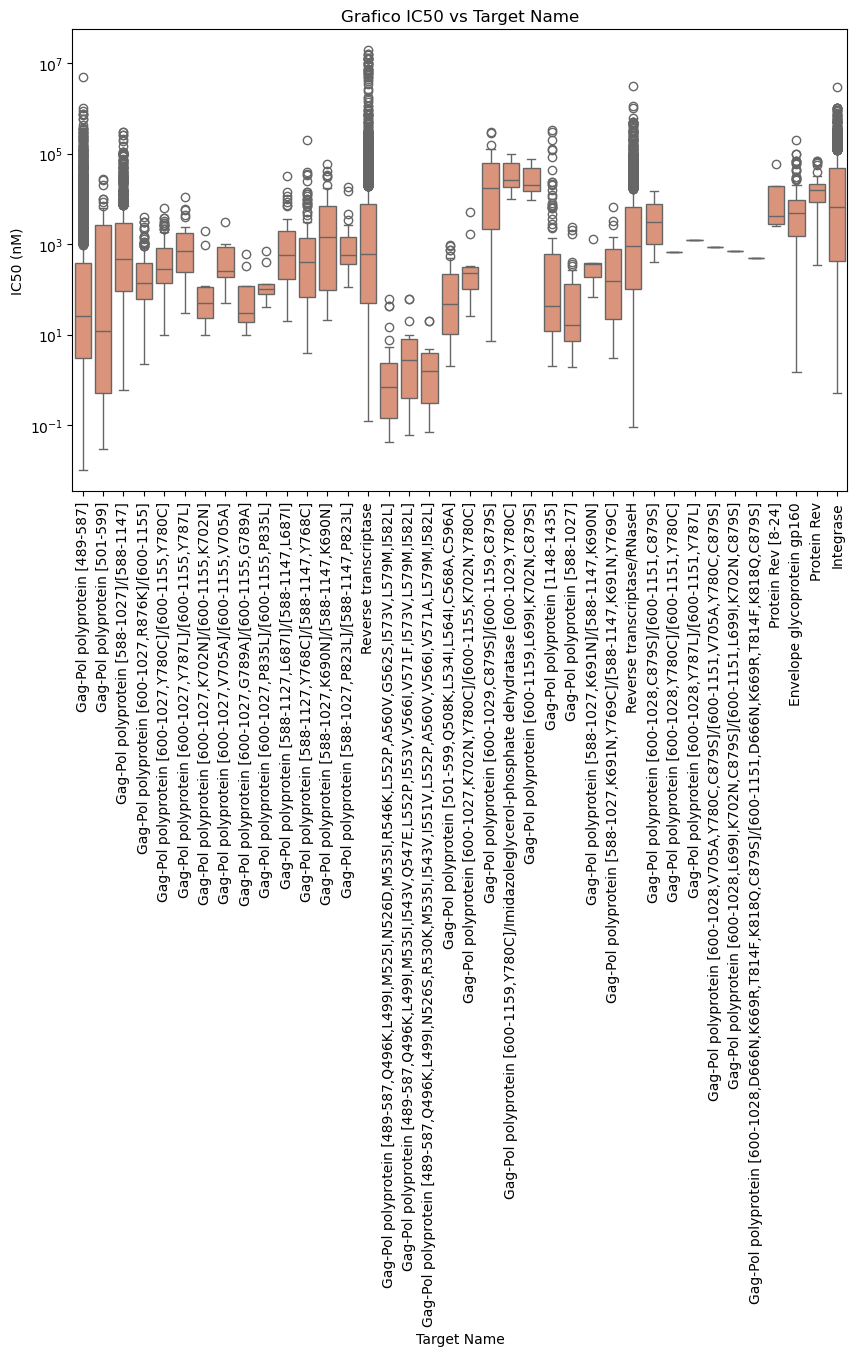

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x ='Target Name', y='IC50 (nM)', data = hiv)

plt.xlabel('Target Name')
plt.ylabel('IC50 (nM)')
plt.yscale('log')
plt.title('Grafico IC50 vs Target Name')

plt.xticks(rotation=90)
plt.show()

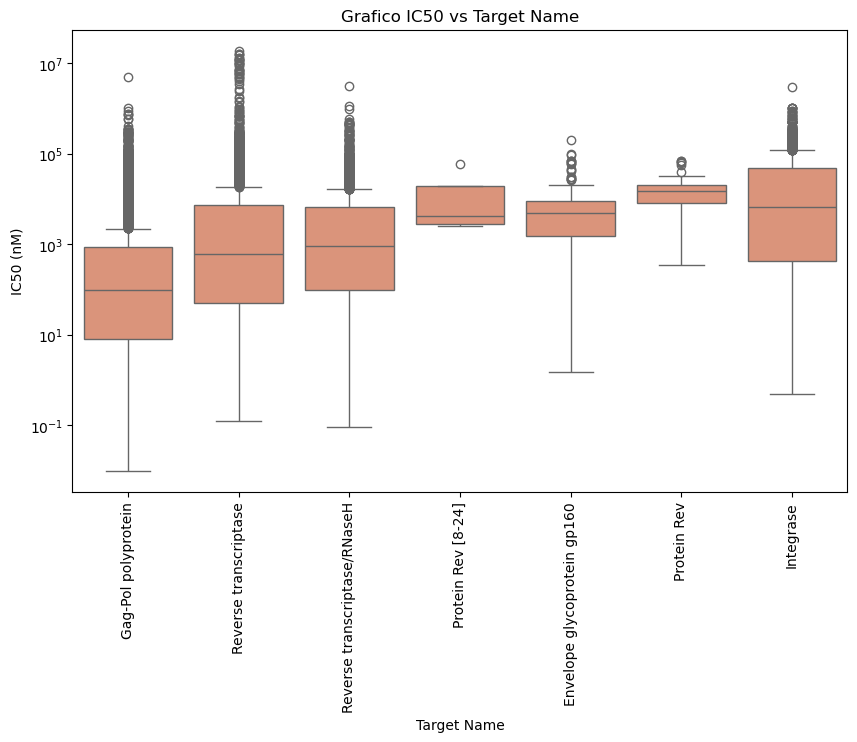

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x ='Target Name', y='IC50 (nM)', data = hiv_condensed)

plt.xlabel('Target Name')
plt.ylabel('IC50 (nM)')
plt.yscale('log')
plt.title('Grafico IC50 vs Target Name')

plt.xticks(rotation=90)
plt.show()

#### Check for differences in distribution

In [18]:
import scipy.stats as stats

In [19]:
hiv_condensed['Log_IC50'] = np.log10(hiv_condensed['IC50 (nM)'])

# Shapiro-Wilk Test
for target in hiv_condensed['Target Name'].unique():
    print(target)
    print(len(hiv_condensed[hiv_condensed['Target Name'] == target]))
    shapiro_stat, shapiro_p = stats.shapiro(hiv_condensed[hiv_condensed['Target Name'] == target]['Log_IC50'])
    print(f"Shapiro-Wilk Test: Statistic = {shapiro_stat}, p-value = {shapiro_p}")

Gag-Pol polyprotein
5201
Shapiro-Wilk Test: Statistic = 0.9959018562056201, p-value = 6.981054683443795e-11
Reverse transcriptase
3492
Shapiro-Wilk Test: Statistic = 0.9916537636643852, p-value = 2.0095696903889046e-13
Reverse transcriptase/RNaseH
2516
Shapiro-Wilk Test: Statistic = 0.9917579495920729, p-value = 8.740579693351219e-11
Protein Rev [8-24]
4
Shapiro-Wilk Test: Statistic = 0.8132403545439889, p-value = 0.12816365516310635
Envelope glycoprotein gp160
200
Shapiro-Wilk Test: Statistic = 0.9205098258791536, p-value = 6.34574008068821e-09
Protein Rev
62
Shapiro-Wilk Test: Statistic = 0.8760612001887664, p-value = 1.4808889374206986e-05
Integrase
2279
Shapiro-Wilk Test: Statistic = 0.9378600133967477, p-value = 7.080978690188888e-30


c:\Users\simon\anaconda3\envs\adattatori\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5201.
  res = hypotest_fun_out(*samples, **kwds)


In [20]:
hiv_condensed['Target Name'] = hiv_condensed['Target Name'].str.replace("Protein Rev [8-24]", "Protein Rev", regex=False)
for target in hiv_condensed['Target Name'].unique():
    print(target)
    print(len(hiv_condensed[hiv_condensed['Target Name'] == target]))
    shapiro_stat, shapiro_p = stats.shapiro(hiv_condensed[hiv_condensed['Target Name'] == target]['Log_IC50'])
    print(f"Shapiro-Wilk Test: Statistic = {shapiro_stat}, p-value = {shapiro_p}")

Gag-Pol polyprotein
5201
Shapiro-Wilk Test: Statistic = 0.9959018562056201, p-value = 6.981054683443795e-11
Reverse transcriptase
3492
Shapiro-Wilk Test: Statistic = 0.9916537636643852, p-value = 2.0095696903889046e-13
Reverse transcriptase/RNaseH
2516
Shapiro-Wilk Test: Statistic = 0.9917579495920729, p-value = 8.740579693351219e-11
Protein Rev
66
Shapiro-Wilk Test: Statistic = 0.9057102961567478, p-value = 0.00010445877577260355
Envelope glycoprotein gp160
200
Shapiro-Wilk Test: Statistic = 0.9205098258791536, p-value = 6.34574008068821e-09
Integrase
2279
Shapiro-Wilk Test: Statistic = 0.9378600133967477, p-value = 7.080978690188888e-30


In [21]:
groups = [group['Log_IC50'].values for name, group in hiv_condensed.groupby('Target Name')]

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA: F-statistic = {f_stat}, p-value = {p_value}")

# Interpretation:
if p_value < 0.05:
    print("Significant difference found between groups.")
else:
    print("No significant difference between groups.")

ANOVA: F-statistic = 499.7585579662976, p-value = 0.0
Significant difference found between groups.


                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                      
           group1                      group2            meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------------------------------------
Envelope glycoprotein gp160          Gag-Pol polyprotein  -1.5686    0.0 -1.8514 -1.2858   True
Envelope glycoprotein gp160                    Integrase  -0.0158    1.0 -0.3052  0.2736  False
Envelope glycoprotein gp160                  Protein Rev   0.5369 0.0664 -0.0202   1.094  False
Envelope glycoprotein gp160        Reverse transcriptase  -0.7186    0.0  -1.004 -0.4333   True
Envelope glycoprotein gp160 Reverse transcriptase/RNaseH   -0.604    0.0 -0.8923 -0.3156   True
        Gag-Pol polyprotein                    Integrase   1.5528    0.0  1.4542  1.6514   True
        Gag-Pol polyprotein                  Protein Rev   2.1055    0.0  1.6194  2.5916   True
        Gag-Pol polyprotein        Rever

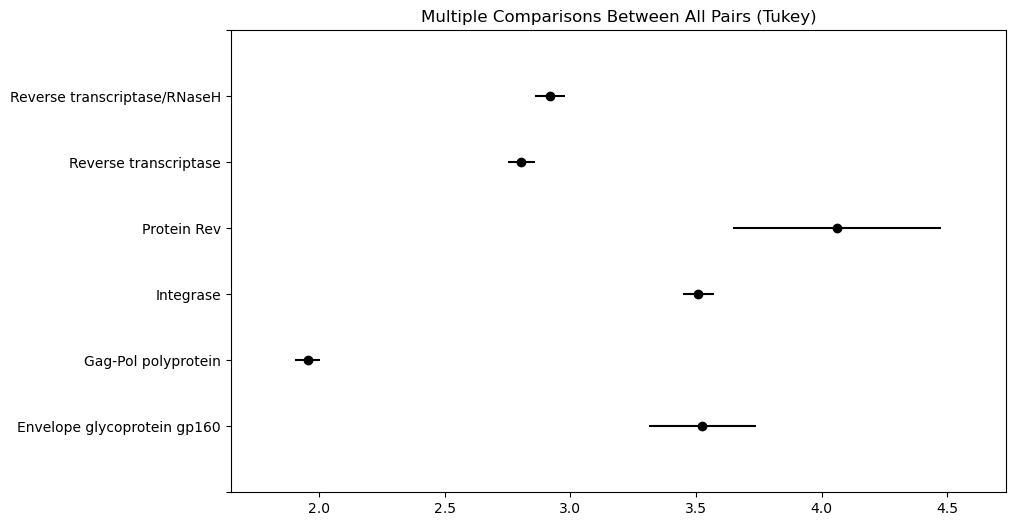

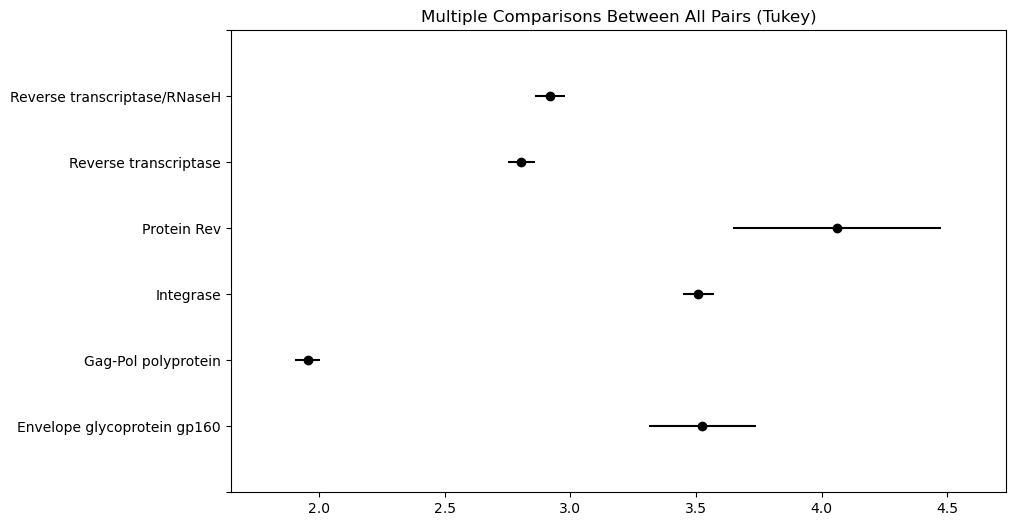

In [22]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD
tukey = pairwise_tukeyhsd(endog=hiv_condensed['Log_IC50'], groups=hiv_condensed['Target Name'], alpha=0.05)
print(tukey)

# Plot Tukey's HSD results
tukey.plot_simultaneous()

In [23]:
t_stat, p_value = stats.ttest_ind(hiv_condensed[hiv_condensed['Target Name'] == 'Reverse transcriptase']['Log_IC50'], hiv_condensed[hiv_condensed['Target Name'] == 'Reverse transcriptase/RNaseH']['Log_IC50'], equal_var=False)  # Set equal_var=False if variances are unequal
print(f"T-Test: t-statistic = {t_stat}, p-value = {p_value}")

if p_value < 0.05:
    print("Significant difference between the two groups.")
else:
    print("No significant difference between the two groups.")

T-Test: t-statistic = -3.407007279565508, p-value = 0.000661190507638598
Significant difference between the two groups.


### Focus on Gag-Pol
Gag-Pol is a long polyprotein, focus on the different loci in the protein